# Упражнение: Word2vec

В этом упражнении вы:

- научитесь генерировать текст с помощью RNN.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

Давайте научимся генерировать текст символ за символом. Вы можете спросить, насколько это практично? На самом деле, подобные модели довольно часто встречаются для задач машинного перевода, задачи составления текста по картинке (image captioning), моделей ответа на вопрос (question answering, QA) и других задач.

# Подготовка данных

В этом ноутбуке мы используем простой текстовый файл.

In [1]:
import string
import random
import re

file = open('datasets/shakespeare.txt').read()
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


Чтобы сделать входные данных из этой одной большой строки, мы разделим строку на части (куски, chunks).

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

. Come, follow us;
We are to speak in public; for this business
Will raise us all.

ANTIGONUS:

PAULINA:
The keeper of the prison, call to him;
let him have knowledge who I am.
Good lady,
No court in E


# Построение модели

Модель будет брать из входного потока символ для шага t-1 и выдавать символ для следующего шага t.
В модели будет три слоя: 
 - линейный слой Embedding для кодирования входных символов во внутреннее пространство кодов,
 - слой с GRU или LSTM (один или несколько), который использует внутренние коды и скрытый слой,
 - декодер, который выдаёт распределение вероятностей для следующего символа.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        # TODO: подставьте сюда слой GRU или LSTM, натренируйте модель, 
        # и посмотрите, что работает лучше (см. упражнение в конце ноутбука).
        self.recurrent = nn.GRU(hidden_size, hidden_size, n_layers)
        # END CODE
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.recurrent(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Входы и выходы

Каждый кусок текста будет преобразован в тензор, конкретнее, в `LongTensor` (используется для целочисленных значений), посредством прохода во всем символам строки и заглядываниям в таблицу кодов символов `all_characters`.

In [4]:
all_characters = string.printable
n_characters = len(all_characters)

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    #TODO: напишите код для преобразования символов строки в коды,
    # используйте all_characters как таблицу преобразования
    #END CODE
    return Variable(tensor)

print(char_tensor('abcDEF'))
assert list(char_tensor('abcDEF').data) == [10, 11, 12, 39, 40, 41]

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



Теперь мы можем подготовить пару из входного и выходного тензора для тренировки на основе метода random_chunk.
Мы будем использовать мини-батч, состоящий из:
 - для входного тензора, из всех символов *кроме последнего* (например, "ab" для входа "abc")
 - для выходного тензора, из всех символов *кроме первого* (например, "bc" для входа "abc")

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

_in, _out = random_training_set()
print(len(random_chunk()), len(_in), len(_out))
assert list(_in[1:].data) == list(_out[:-1].data)

201 200 200


# Использование нейросети

Чтобы сгенерировать данные с помощью нашей обученной нейросети, мы будем подавать нейросети по одному символу за раз, и использовать выходы нейросети как распределение вероятностей для следующего символа, и потом повторять этот процесс. Для начала генерации мы подаём стартовую строку (по крайней мере один символ), из которой мы строим состояние скрытого слоя, которое нам будет нужно для генерации последующих символов.

In [6]:
def evaluate(net, prime_str='A', predict_len=100, temperature=0.8):
    hidden = net.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Используем стартовую строку чтобы получить прошлое скрытое состояние
    for p in range(len(prime_str) - 1):
        _, hidden = net(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = net(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Тренировка

Функция для вывода прошедшего времени:

In [7]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%d:%02d' % (m, s)

Функция тренировки

In [8]:
def train(net, opt, inp, target):
    hidden = net.init_hidden()
    net.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = net(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    opt.step()

    return loss.data[0] / chunk_len

Определяем тренировочные параметры, инициализируем модель и начинаем тренировку:

In [9]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

net = Net(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(net, optimizer, *random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) cost=%.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(net, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[0:13 (100 5%) cost=2.3444]
Whit barle and I doon land thall gor whand gonses
Thait and I and the's you nop?
Oig, rollill, thee di 

[0:25 (200 10%) cost=2.2026]
What of ven math me chinglee,
IO Ois feeming ish in in knou hill the for not ungars
Severe:
The hing w 

[0:35 (300 15%) cost=1.9093]
Whear:
Noo thou cistious since his for laven are anse, wountle a looud as cavoks, hathes;
And sut oven 

[0:44 (400 20%) cost=1.8833]
Whuer, wisleer,
Wing,
Dim and sit thom I and make, be me there and not leve and be tring.
Whand thou m 

[0:54 (500 25%) cost=1.8968]
Wher overd your.

CORMIOLOLANUS:
Whist thy of I kerwacund the coust, ever
And thmind blood-she cith my 

[1:03 (600 30%) cost=1.9830]
Whers.

JURICH:
I bet is shour dood yeard,
But int sustle the sir, for duad:
And the bay, tery oter?

 

[1:13 (700 35%) cost=1.7144]
Whond more known,
To me life vesving hat
Where in to sild net that with be worly.

CORIOLANUS:
To prin 

[1:22 (800 40%) cost=1.7892]
Whan thee confieven's and lifore



# Рисуем значение функции потерь во время тренировки

Посмотрим, как сеть училась, нарисовав график функции потерь (мы сохранили его в переменной all_losses):

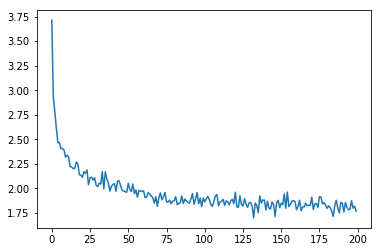

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses);

# Использование при разных "температурах"

В функции `evaluate` выше, каждый раз, когда мы делали предсказание, значения выходного слоя делились на аргумент "температуры" (`temperature`). Использование более высокой температуры позволяет сделать все вероятности более равновероятными, и даёт "более случайные" значения на выходе. Использование более низких значений (меньше 1) даёт больший вклад для значений с высокими вероятностями. Если мы двигаем температуру к нулю, мы оставляем только наиболее вероятные выходы.

Давайте посмотрим, что выдаёт сеть при разных значениях этого параметра:

In [11]:
print(evaluate(net, 'Th', 200, temperature=0.8))

Thow again with he praseding and he tale;
Cather, who be he seen would my have would be come then I dake hath in them.

PETER:
I a to her him, he staden's.

Sponove in they
For freit, he manged rebrease


Lower temperatures are less varied, choosing only the more probable outputs:

In [12]:
print(evaluate(net, 'Th', 200, temperature=0.2))

Than the we the with the be the will the state the with the state the with and he with his hath the with son the be the strange the with the shall the prease the stay,
And the will the with the will the


Higher temperatures more varied, choosing less probable outputs:

In [13]:
print(evaluate(net, 'Th', 200, temperature=1.4))

Ths: sthrurs, Dive?
Uour highinket Mefep'-hack
vequs hif 'ngongce?
fervbet it ulduriendss: I rusk the size
ciecery timper: trektor excarys?

TRUMIO:
Peet coaver,, mseanters, she peasider? what frovest.



# Упражнение
Заполните TODO, подберите "на глаз" параметры обучения, и обучите нейросеть в трёх разных ноутбуках:
 - с GRU размера 256
 - с LSTM размера 256
 - с двумя слоями LSTM размера 128
 
Приведите примеры сгенерированного текста